# Deep Convolutional GAN on CIFAR-10 Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader

In [2]:
# Set random seed for reproducibility
manualSeed = 999
torch.manual_seed(manualSeed)

# Parameters
batch_size = 128
image_size = 64
nc = 3  # Number of channels in the training images
nz = 100  # Size of z latent vector (i.e., size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
lr = 0.0002
beta1 = 0.5

# Create the dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
dataset = dsets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 170498071/170498071 [00:03<00:00, 48112614.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## We now define the DCGAN Model
### Generator Network

In [4]:
# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


### Discriminator Network

In [5]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input)


## Training our DCGAN Model
## NOTE!
### Since CIFAR-10 is a big dataset and the available hardware with me (Google GPUs) take exorbitantly high amount of time to train it, I have done some tweaking of hyperparameters to ease the training instead of cutting down the dataset as I felt that reducing the dataset compromisizes on the overall project.

## Model Training Adjustments

- **Generator and Discriminator Complexity Reduction:**
  - The complexity of the generator and discriminator has been reduced by using fewer filters to simplify the model architecture.
######
- **Batch Size:**
  - A batch size of 128 is utilized to improve gradient stability during training.
######
- **Epoch Limitation:**
  - The number of epochs is limited to 30 to quickly observe the training progress and avoid overfitting.



In [6]:
num_epochs = 30

# Create the generator
netG = Generator().cuda()

# Create the discriminator
netD = Discriminator().cuda()

# Loss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device='cuda')

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
img_list = []
G_losses = []
D_losses = []
iters = 0
min_G_loss = float('inf')
min_D_loss = float('inf')

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].cuda()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device='cuda')
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device='cuda')
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Track minimum losses
        if errG.item() < min_G_loss:
            min_G_loss = errG.item()
        if errD.item() < min_D_loss:
            min_D_loss = errD.item()

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


## Studying the Loss Curves and Minimum Error


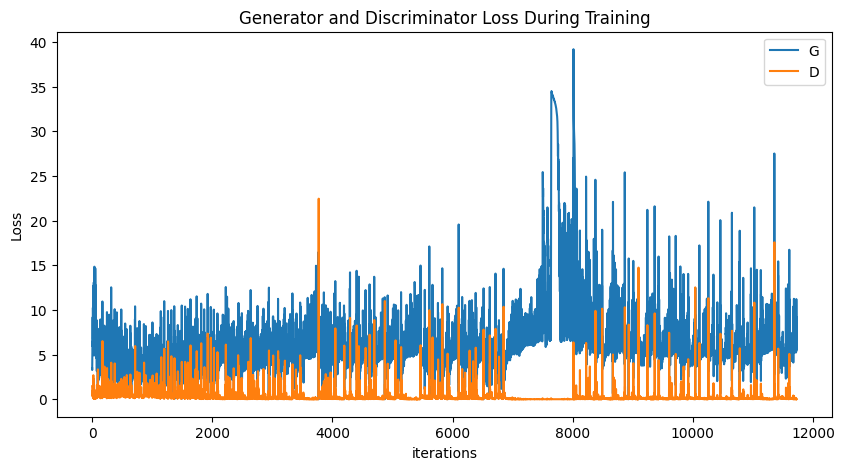

In [7]:
# Plot the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Loss Curve Analysis
##### During training, the Generator loss is almost 5 units greater than the Discriminator loss, as observed in the above plots.

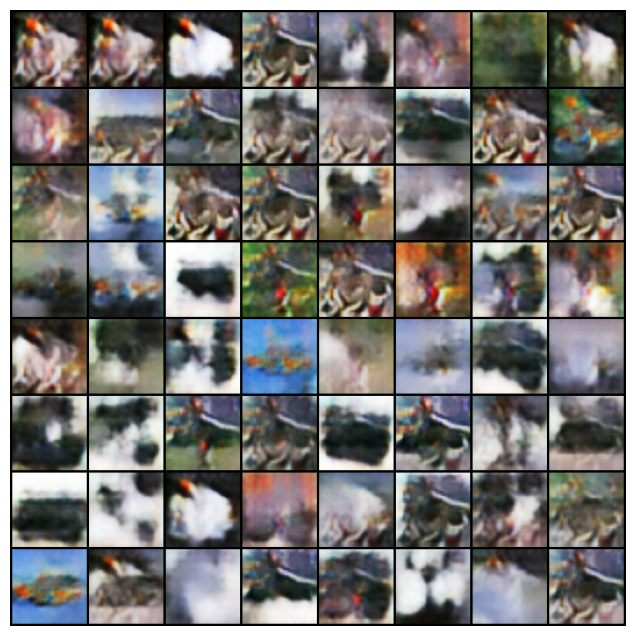

Minimum Generator Loss: 6.179214688017964e-05
Minimum Discriminator Loss: 1.4305963304650504e-05


In [8]:
# Display some generated images
import numpy as np
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)))] for i in img_list]
plt.show()

# Print the minimum error
print(f"Minimum Generator Loss: {min_G_loss}")
print(f"Minimum Discriminator Loss: {min_D_loss}")

## Experiment Results

### Image Quality
The obtained images have very few recognizable features, likely due to hardware limitations affecting computation.

### Losses
- **Minimal Generator loss:** $6.179214688017964 \times 10^{-5}$
- **Minimal Discriminator loss:** $1.4305963304650504 \times 10^{-5}$



## Modifications in the New Model

### Updated Generator
- Added intermediate layers to allow the generator to learn more complex features.

### Learning Rate
- Reduced the learning rate to allow for smoother training.

### Training and Debugging
- Retrained the models and logged the losses and generated images to observe the performance improvements.

### Reference to Literature Paper
In accordance with ideas presented in the literature paper ["An Introduction to Deep Generative Modeling"](https://arxiv.org/pdf/2103.05180):

- **Change in Generator Network:**
  - Targeted to maximize $log(D(G(z)))$.
######
- **Change in Discriminator Network:**
  - Targeted to maximize $\log(D(x)) + \log(1 - D(G(z)))$.


In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [11]:
# Hyperparameters
lr = 0.0001
beta1 = 0.5

# Create the updated generator and discriminator
netG_updated = Generator().cuda()
netD_updated = Discriminator().cuda()

# Setup Adam optimizers for both G and D
optimizerD_updated = optim.Adam(netD_updated.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_updated = optim.Adam(netG_updated.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop for updated models
img_list_updated = []
G_losses_updated = []
D_losses_updated = []
iters_updated = 0
min_G_loss_updated = float('inf')
min_D_loss_updated = float('inf')

print("Starting Training Loop for Updated Models...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_updated.zero_grad()
        real_cpu = data[0].cuda()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device='cuda')
        output = netD_updated(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device='cuda')
        fake = netG_updated(noise)
        label.fill_(fake_label)
        output = netD_updated(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD_updated.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_updated.zero_grad()
        label.fill_(real_label)
        output = netD_updated(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG_updated.step()

        # Save Losses for plotting later
        G_losses_updated.append(errG.item())
        D_losses_updated.append(errD.item())

        # Track minimum losses
        if errG.item() < min_G_loss_updated:
            min_G_loss_updated = errG.item()
        if errD.item() < min_D_loss_updated:
            min_D_loss_updated = errD.item()

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters_updated % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG_updated(fixed_noise).detach().cpu()
            img_list_updated.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters_updated += 1

Starting Training Loop for Updated Models...


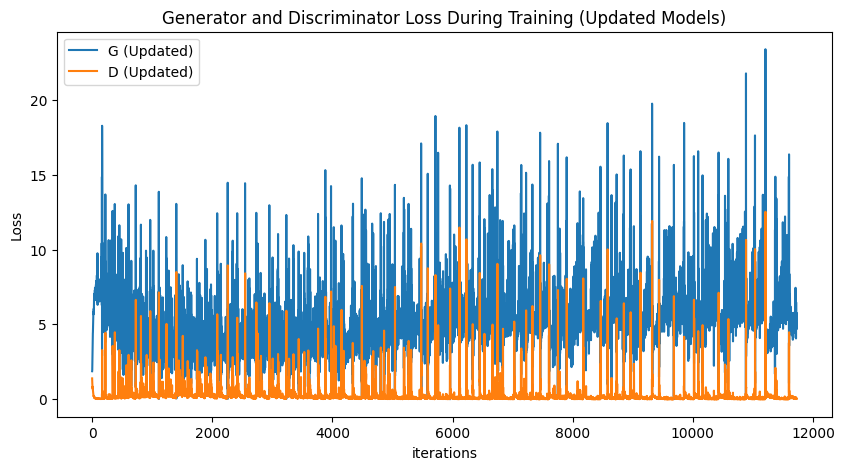

In [12]:
# Plot the loss curves for the updated models
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (Updated Models)")
plt.plot(G_losses_updated,label="G (Updated)")
plt.plot(D_losses_updated,label="D (Updated)")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Loss Curve Analysis

### Observations
#### During training, the Generator loss is almost 5 units greater than the Discriminator loss, as observed in the above plots.


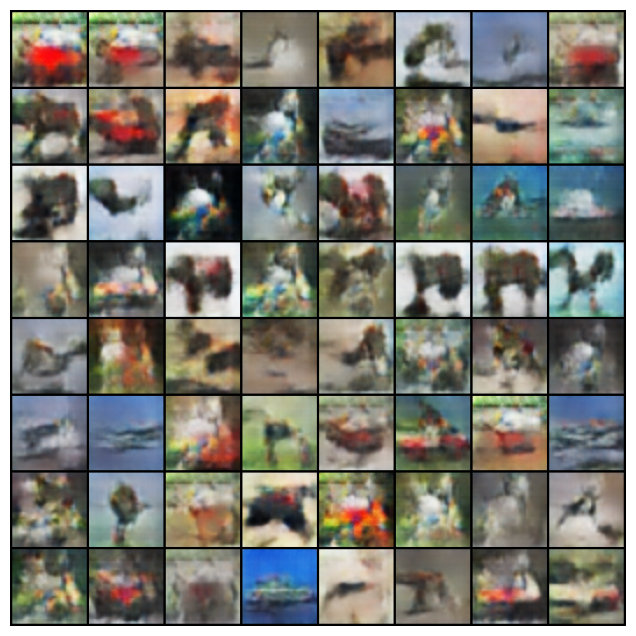

Minimum Generator Loss (Updated): 0.0007413008133880794
Minimum Discriminator Loss (Updated): 0.00029181287391111255


In [13]:
# Display some generated images from updated models
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)))] for i in img_list_updated]
plt.show()

# Print the minimum error for the updated models
print(f"Minimum Generator Loss (Updated): {min_G_loss_updated}")
print(f"Minimum Discriminator Loss (Updated): {min_D_loss_updated}")


## Experiment Results

### Image Quality
The obtained images now have a few more recognizable features, after the addition of multiple layers.

### Losses
- **Minimal Generator loss (Updated) :** $7.413008133880794 \times 10^{-4}$
- **Minimal Discriminator loss (Updated) :** $2.9181287391111255 \times 10^{-4}$


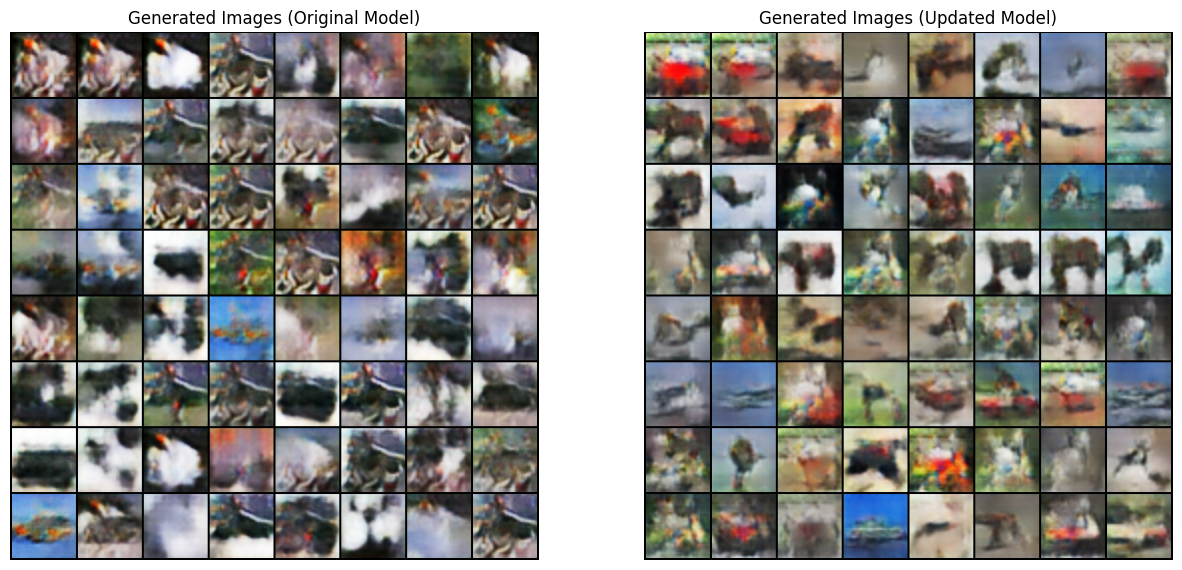

In [14]:
# Collate a sample of generated images from both iterations for comparison
import matplotlib.pyplot as plt
import numpy as np

# Plot original model generated images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Generated Images (Original Model)")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True), (1, 2, 0)))

# Plot updated model generated images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Generated Images (Updated Model)")
plt.imshow(np.transpose(vutils.make_grid(img_list_updated[-1], padding=2, normalize=True), (1, 2, 0)))

plt.show()

### Conclusions

After comparing images from both iterations:

- **Observation:** The images generated by the updated model appear to be slightly better than the ones from the original model.
- **Similarity:** Clarity and resolution are almost similar in both sets of images.
- **Difference:** The images generated by the updated model have fewer identical images compared to those generated by the original model.